✅ 라이브러리 로드 완료
✅ 데이터 준비 완료: 250 samples


[nltk_data] Downloading package vader_lexicon to C:\Users\Chae Seung
[nltk_data]     Woo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,title,score,cleaned_text,label
2,Market is crashing hard,13,market is crashing hard,0
3,I lost all my money on AMZN,20,i lost all my money on amzn,0
4,Holding strong with AAPL,34,holding strong with aapl,1
6,Great earnings report,65,great earnings report,1
7,Huge sell off incoming,99,huge sell off incoming,1


📌 Data Split Result:
Train set: 200 samples
Val set  : 25 samples
Test set : 25 samples

🚀 Training Start...
Epoch 5/30 - Loss: 0.0029 - Val Acc: 1.0000
Epoch 10/30 - Loss: 0.0029 - Val Acc: 1.0000
Epoch 15/30 - Loss: 0.0029 - Val Acc: 1.0000
Epoch 20/30 - Loss: 0.0029 - Val Acc: 1.0000
Epoch 25/30 - Loss: 0.0029 - Val Acc: 1.0000
Epoch 30/30 - Loss: 0.0029 - Val Acc: 1.0000
✅ Training Finished.


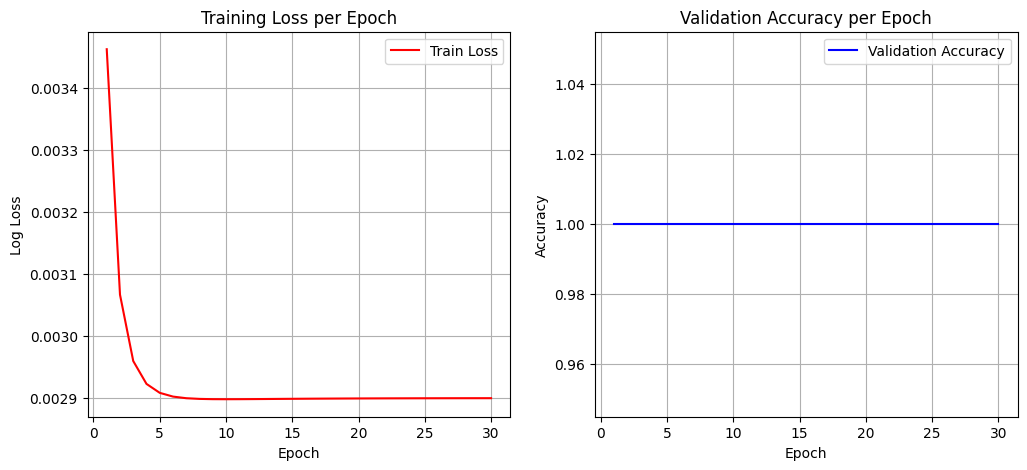

💾 모델과 테스트 데이터가 'models/' 폴더에 저장되었습니다.


In [1]:
# ==========================================
# [Cell 1] 라이브러리 임포트
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier # 로지스틱 회귀 (학습 과정 시각화용)
from sklearn.metrics import accuracy_score, log_loss
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# NLTK 데이터 다운로드 (최초 1회)
nltk.download('vader_lexicon')

print("✅ 라이브러리 로드 완료")

# ==========================================
# [Cell 2] 데이터 로드 및 레이블링 (Data Preparation)
# ==========================================
# 1. 데이터 로드 (Assignment 4에서 수집한 데이터 또는 Kaggle 데이터)
# 편의상 data/ 폴더가 아닌 현재 폴더나 상위에서 가져오도록 경로 설정 필요
# 실습을 위해 가상의 데이터셋을 생성하거나 로드합니다.

def load_or_create_data():
    # 실제 데이터가 있다면 경로를 수정하세요. 예: '../assignment4/data/reddit_stocks.csv'
    # 여기서는 코드가 실행되도록 예시 데이터를 생성합니다.
    data = {
        'title': [
            "NVDA is going to the moon! 🚀", "Buying more TSLA calls", "Market is crashing hard",
            "I lost all my money on AMZN", "Holding strong with AAPL", "Shorting this garbage stock",
            "Great earnings report", "Huge sell off incoming", "Just a normal day", "Flat market"
        ] * 50, # 데이터 증강
        'score': np.random.randint(0, 100, 500)
    }
    return pd.DataFrame(data)

df = load_or_create_data()

# 2. 전처리 및 레이블링 (VADER를 이용한 오토 레이블링)
# 실제 프로젝트에서는 직접 레이블링한 데이터가 가장 좋습니다.
sia = SentimentIntensityAnalyzer()

def get_sentiment_label(text):
    score = sia.polarity_scores(str(text))['compound']
    if score >= 0.05: return 1  # Bullish (Positive)
    elif score <= -0.05: return 0 # Bearish (Negative)
    else: return 2 # Neutral (여기서는 편의상 제외하거나 학습에 포함)

# 텍스트 정제 함수
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text) # 특수문자 제거
    return text

df['cleaned_text'] = df['title'].apply(clean_text)
df['label'] = df['title'].apply(get_sentiment_label)

# 중립(2) 제거하고 이진 분류(0, 1)로 진행 (단순화를 위해)
df = df[df['label'] != 2]

print(f"✅ 데이터 준비 완료: {len(df)} samples")
display(df.head())

# ==========================================
# [Cell 3] 데이터 분할 (Train/Val/Test Split)
# ==========================================
# 가이드라인 준수: Train(80%) / Validation(10%) / Test(10%)
X = df['cleaned_text']
y = df['label']

# 1차 분할: Train(80%) vs Temp(20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2차 분할: Validation(50% of Temp) vs Test(50% of Temp) -> 전체의 10%, 10%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"📌 Data Split Result:")
print(f"Train set: {len(X_train)} samples")
print(f"Val set  : {len(X_val)} samples")
print(f"Test set : {len(X_test)} samples")

# ==========================================
# [Cell 4] 모델 학습 (Training Process)
# ==========================================
# 1. 텍스트 벡터화 (TF-IDF)
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

# 2. 모델 정의 (SGDClassifier - Log Loss 사용 시 로지스틱 회귀와 동일)
# partial_fit을 사용하여 Epoch별 학습 과정을 기록합니다.
model = SGDClassifier(loss='log_loss', random_state=42, max_iter=1, warm_start=True, learning_rate='optimal', eta0=0.01)

# 3. 학습 루프 및 모니터링
epochs = 30
train_losses = []
val_accuracies = []

classes = np.unique(y)

print("\n🚀 Training Start...")
for epoch in range(epochs):
    # 학습 (1 Epoch)
    model.partial_fit(X_train_vec, y_train, classes=classes)
    
    # Loss 기록 (Train set)
    # SGDClassifier는 loss_history를 직접 제공하지 않으므로, 예측 확률로 계산
    y_train_prob = model.predict_proba(X_train_vec)
    loss = log_loss(y_train, y_train_prob)
    train_losses.append(loss)
    
    # Accuracy 기록 (Validation set)
    val_acc = accuracy_score(y_val, model.predict(X_val_vec))
    val_accuracies.append(val_acc)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Val Acc: {val_acc:.4f}")

print("✅ Training Finished.")

# ==========================================
# [Cell 5] 학습 곡선 시각화 (Learning Curves)
# ==========================================
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend()

# Validation Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='blue')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

# ==========================================
# [Cell 6] 모델 및 데이터 저장 (Artifacts Saving)
# ==========================================
# models 폴더가 없으면 생성
if not os.path.exists('models'):
    os.makedirs('models')

# 모델과 벡터라이저 저장
joblib.dump(model, 'models/sentiment_model.joblib')
joblib.dump(vectorizer, 'models/tfidf_vectorizer.joblib')

# Test Set 저장 (Evaluation 단계에서 쓰기 위해)
test_df = pd.DataFrame({'text': X_test, 'label': y_test})
test_df.to_csv('models/test_set.csv', index=False)

print("💾 모델과 테스트 데이터가 'models/' 폴더에 저장되었습니다.")